# 4-point line analysis using the NBA API

Inspired by JxmyHighroller's [youtube video](https://www.youtube.com/watch?v=XyihDTdpF8w&t=522s) about the hypothetical addition of a 4 point line, we use the NBA API to answer a few different questions.

<ol>
<li>How many games in the 2022/2023 season (including playoffs), would have had the result flipped (win to loss or viceversa) if the baskets made at distance >= 30ft were counted as 4 points?</li>
<li>What is the answer to the first question for other seasons?</li>
<li>What happens if we change the 4-point line to a different distance?</li>
</ol>

### Spoiler alert: JxmyHighroller miscounted

We begin by importing the relevant packages and endpoints from the NBA API.

In [1]:
import requests
import json
import pandas as pd
import matplotlib
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import leaguegamefinder

We now build a function that for a given season, returns a data frame containing info of all the games played, including playoffs.

In [2]:
def findAllGames(season):
    # We query leaguegamefinder to get a record of all regular season games in the season
    result_regular = leaguegamefinder.LeagueGameFinder(season_nullable = season,league_id_nullable = '00',season_type_nullable = 'Regular Season')

    # We store this in a data frame
    all_games_regular = pd.DataFrame(result_regular.get_data_frames()[0])

    # We query leaguegamefinder to get a record of all playoff games in the season
    result_playoffs = leaguegamefinder.LeagueGameFinder(season_nullable = '2022-23',league_id_nullable = '00',season_type_nullable = 'Playoffs')

    # We store this in a data frame
    all_games_playoffs = pd.DataFrame(result_playoffs.get_data_frames()[0])

    #Finally we combine the two data frames, and get a list of the unique game ids, which we will use later.
    all_games = pd.concat([all_games_regular,all_games_playoffs])
    return all_games

We can use the shotchartdetail endpoint to get a record of all made shots in a specific game.

In [3]:
def allShots(season):
    #The following record contains all made shots of the regular season, note the use of '0' to allow any value
    shot_details_regular = shotchartdetail.ShotChartDetail(
                team_id = '0',
                player_id = '0',
                context_measure_simple = 'PTS',
                season_nullable = season,
                season_type_all_star = 'Regular Season')

    #The following record contains all made shots of the playoffs
    shot_details_playoffs = shotchartdetail.ShotChartDetail(
                team_id = '0',
                player_id = '0',
                context_measure_simple = 'PTS',
                season_nullable = season,
                season_type_all_star = 'Playoffs')

    #We combine the information in a single data frame containing all made shots of the season
    shot_df_regular = pd.DataFrame(shot_details_regular.get_data_frames()[0])
    shot_df_playoffs = pd.DataFrame(shot_details_playoffs.get_data_frames()[0])
    shot_df_all = pd.concat([shot_df_regular,shot_df_playoffs])
    return shot_df_all

Given a specific game id, we can now filter through the database of shots, find all the shots made in a single game, and check if the final result would have changed with a 4-point line. We output two arrays, the first one representing the game ids of the games that would have changed result from a win to a loss, and a second one if the game would have gone to an extra overtime.

In [4]:
def findAllGamesChanged(season,line_distance):
    #this is used to store the ids of the games were the result would have been different
    games_changed = []
    games_to_overtime = []

    #get all the games played
    all_games = findAllGames(season)

    #get all the shots
    shot_df_all = allShots(season)

    #get all ids making sure that all games are in both databases, to avoid errors
    allIds = set(shot_df_all['GAME_ID'].unique()).intersection(set(all_games['GAME_ID'].unique()))
    
    #iterate through all the unique game ids of the season
    for g_id in allIds:
        #get the teams names and the points scored for the specific game
        full_game = all_games[all_games.GAME_ID == g_id]
        two_teams = full_game['TEAM_NAME'].unique()
        points_team_zero = full_game[full_game.TEAM_NAME == two_teams[0]]['PTS'].unique()[0]
        points_team_one = full_game[full_game.TEAM_NAME == two_teams[1]]['PTS'].unique()[0]

        #the value pm denoted the difference in score, in particular team_zero won the game iff pm is positive
        pm =  points_team_zero-points_team_one

        #filter the shots dataframe to this specific game
        shot_df = shot_df_all[shot_df_all.GAME_ID== g_id]

        #we need to pay attention to possible overtimes, the array periods contains the number of quarters
        #if there was no overtime, periods = [1,2,3,4]
        periods = shot_df['PERIOD'].unique()

        #filter the shots to the 30+ footers
        four_pointers = shot_df[shot_df.SHOT_DISTANCE >= line_distance]

        #in order to take care of possible overtimes, we split the 4 pointers according to whether they were made in regular time
        #or in a specific overtime
        team_zero_gains = [len(four_pointers[(four_pointers.TEAM_NAME == two_teams[0]) & (four_pointers.PERIOD <= x)]) for x in periods]
        team_one_gains = [len(four_pointers[(four_pointers.TEAM_NAME == two_teams[1]) & (four_pointers.PERIOD <= x)]) for x in periods]
        #here team_zero_gains has length 1+ number of overtimes, and contains the appropriate number of 4 pointers made by
        #team_zero
        team_zero_gains = [team_zero_gains[3]] + [team_zero_gains[i]-team_zero_gains[i-1] for i in range(4,len(team_zero_gains))]
        team_one_gains = [team_one_gains[3]] + [team_one_gains[i]-team_one_gains[i-1] for i in range(4,len(team_one_gains))]
    
        #the array pms contains the various swings in points given by the 4-point line, with the inclusion of the final difference
        #at the end
        pms = [0 for x in range(len(team_zero_gains)-1)] + [pm]

        #we are now ready to check if the result would have changed
        for i in range(len(team_zero_gains)):
            #in the following case, the team that won the game, scored more 4-pointers before going into another overtime,
            #so we stop, knowing that the result would have stayed the same
            if pms[i] == 0 and (pm)*(pms[i]+team_zero_gains[i]-team_one_gains[i]) > 0:
                break
            #if there is a 4-point differential of opposite sign to the final score difference, it now means that the result
            #would have changed. Note that changing from a strict inequality to <=, includes all games that would have been forced
            #into overtime
            if (pm)*(pms[i]+team_zero_gains[i]-team_one_gains[i]) <= 0:
                if (pm)*(pms[i]+team_zero_gains[i]-team_one_gains[i]) == 0:
                    games_to_overtime.append(g_id)
                else:
                    games_changed.append(g_id)
                break
    return([games_changed,games_to_overtime])

In [6]:
games_changed = findAllGamesChanged('2022-23',30)
len(games_changed[0])

9

Answer to Q1: There are 9 games that would have had the result flipped. In his video, JxmyHighroller claimed that there were only 2 games where this happened. Let's see where his mistake was with an example.

In [7]:
#we can print all the relevant matchups, where the first team is the one that originally lost
all_games = findAllGames('2022-23')
full_game = all_games[(all_games.GAME_ID.isin(games_changed[0])) & (all_games.WL == 'L')]
print(full_game[['MATCHUP','GAME_DATE']].to_string(index=False))

    MATCHUP  GAME_DATE
LAC vs. SAC 2023-02-24
  LAL @ BOS 2023-01-28
  GSW @ BOS 2023-01-19
  ATL @ GSW 2023-01-02
CHA vs. DET 2022-12-14
CHI vs. NYK 2022-12-14
  CHI @ ATL 2022-12-11
BOS vs. MIA 2022-12-02
  GSW @ CHA 2022-10-29


Consider for example the last game, which ended 120-113 in favour of Charlotte after one overtime. In this game Jordan Poole was the only one making a 30+ footer, and since this happened in regular time, it would have won GSW the game! However if one counts this as only one extra point for GSW, since the score was +7 for CHA, an easy mistake!

We can now easily extend the result to the last 23 seasons!

In [9]:
all_seasons = ["200"+str(x)+"-0"+str(x+1) for x in range(9)]+["2009-10"]+["20"+str(x)+"-"+str(x+1) for x in range(10,23)]
all_changes = []
for season in all_seasons:
    all_changes.append([len(x) for x in findAllGamesChanged(season,30)])

In [11]:
df2 = pd.DataFrame(all_changes, columns=["Games Flipped","Games to Overtime"],index=all_seasons)

In [13]:
df2

,Games Flipped,Games to Overtime
2000-01,4,79
2001-02,1,69
2002-03,2,84
2003-04,4,67
2004-05,3,76
2005-06,1,84
2006-07,2,83
2007-08,2,61
2008-09,2,65
2009-10,1,71


We plot the number of games flipped (from win to loss or viceversa).

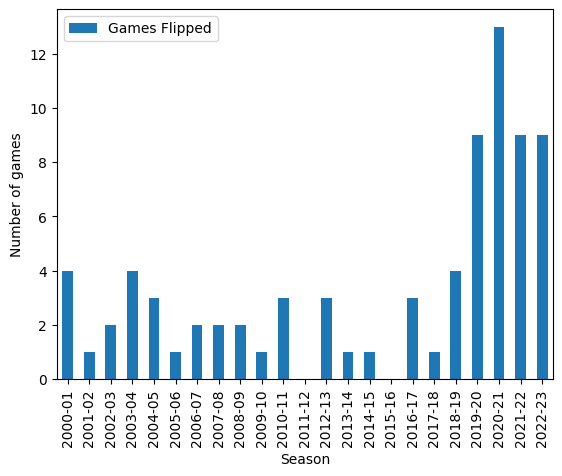

In [15]:
plot1 = df2[['Games Flipped']].plot.bar(stacked=True).set(xlabel="Season", ylabel="Number of games")

We conclude by looking at the impact of different distances for the 4-point line on last season.

In [16]:
games_flipped_by_distance = []
for d in range(23,50):
    games_flipped_by_distance.append(findAllGamesChanged('2022-23',d))

In [18]:
number_flipped_games = [len(x[0]) for x in games_flipped_by_distance]
df3 = pd.DataFrame(number_flipped_games, columns=["Games Flipped"],index=range(23,50))

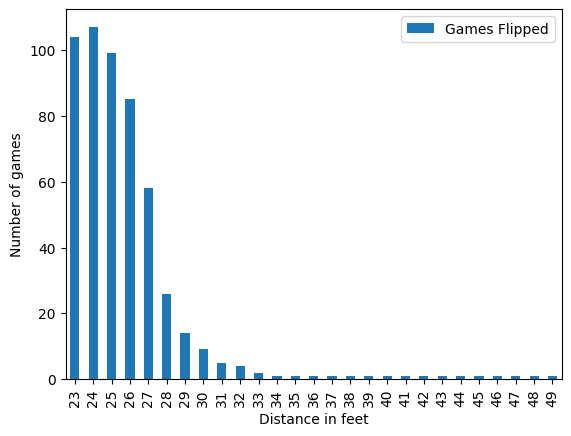

In [19]:
plot2 = df3.plot.bar(stacked=True).set(xlabel="Distance in feet", ylabel="Number of games")

The tale is given by the following game.

In [23]:
all_games = findAllGames('2022-23')
full_game = all_games[(all_games.GAME_ID==games_flipped_by_distance[-1][0][0]) & (all_games.WL == 'L')]
print(full_game[['MATCHUP','GAME_DATE']].to_string(index=False))

  MATCHUP  GAME_DATE
GSW @ BOS 2023-01-19


Indeed Steph Curry scored from beyond half court, and that would have won the game in regulation, instead of losing in overtime.